# Sistema de Detecção e Reconhecimento Facial

## Projeto: Detecção e Reconhecimento Facial usando LFW Dataset

**Tipo:** Aprendizado Supervisionado  
**Base de dados:** LFW (Labeled Faces in the Wild)  
**Descrição:** Sistema que detecta rostos e reconhece pessoas em imagens ou vídeo

In [1]:
# Instalação de dependências
%pip install scikit-learn scikit-image opencv-python mtcnn tensorflow matplotlib numpy pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.8 MB/s eta 0:00:00


In [2]:
# Importação de bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

## 1. Carregamento e Preparação dos Dados LFW

In [3]:
# Carregar dataset LFW
# min_faces_per_person: mínimo de faces por pessoa (filtra pessoas com poucas imagens)
# resize: redimensiona as imagens para acelerar o processamento
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Informações sobre o dataset
n_samples, h, w = lfw_people.images.shape
n_features = h * w
n_classes = lfw_people.target_names.shape[0]

print(f"\nDataset carregado:")
print(f"  - Número de amostras: {n_samples}")
print(f"  - Dimensões das imagens: {h}x{w}")
print(f"  - Número de features: {n_features}")
print(f"  - Número de classes (pessoas): {n_classes}")
print(f"\nPessoas no dataset:")
for i, name in enumerate(lfw_people.target_names):
    print(f"  {i}: {name}")

# Dados e labels
X = lfw_people.data
y = lfw_people.target
target_names = lfw_people.target_names


Dataset carregado:
  - Número de amostras: 1288
  - Dimensões das imagens: 50x37
  - Número de features: 1850
  - Número de classes (pessoas): 7

Pessoas no dataset:
  0: Ariel Sharon
  1: Colin Powell
  2: Donald Rumsfeld
  3: George W Bush
  4: Gerhard Schroeder
  5: Hugo Chavez
  6: Tony Blair


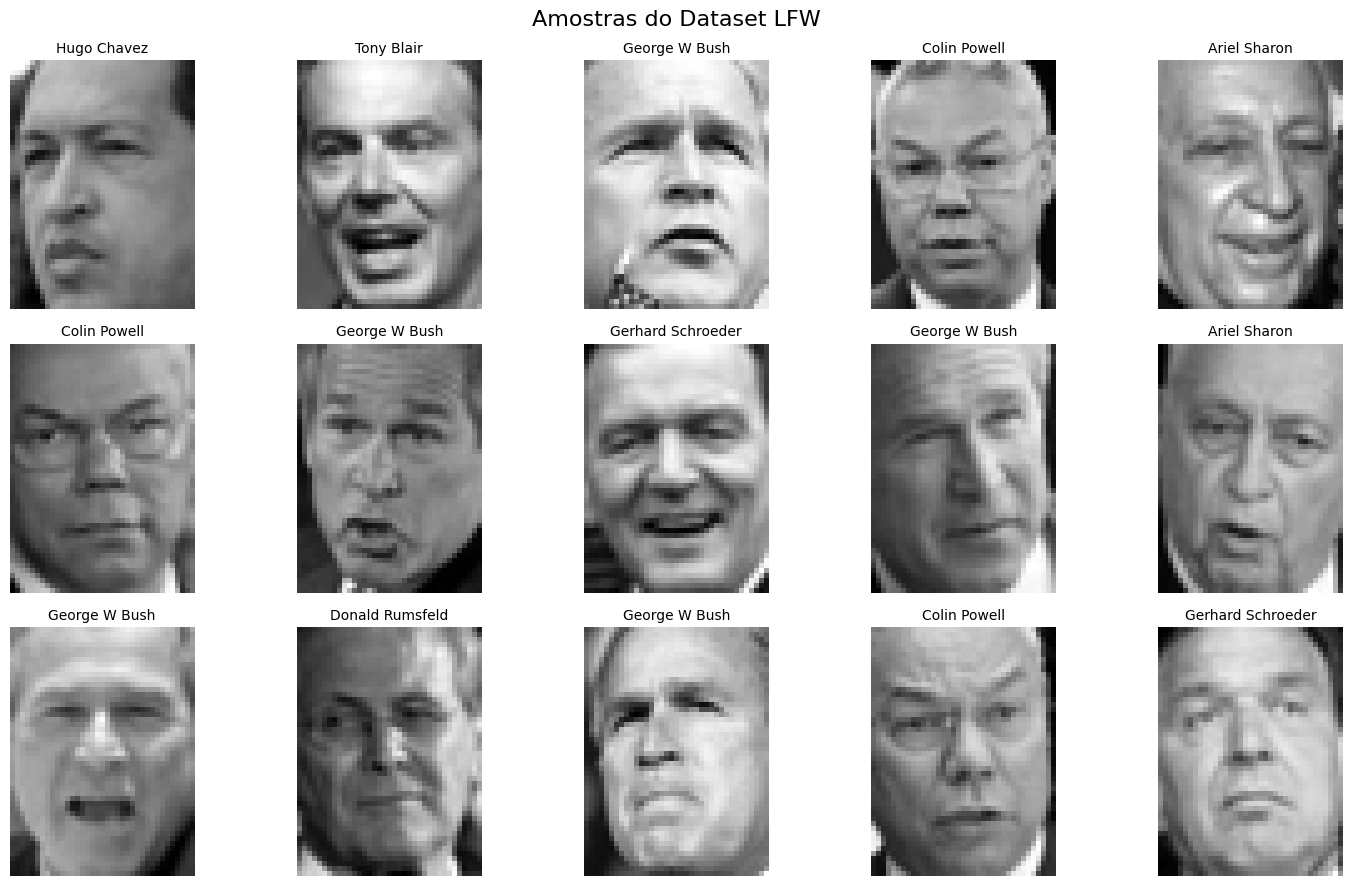

In [4]:
# Visualizar algumas imagens do dataset
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
fig.suptitle('Amostras do Dataset LFW', fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < n_samples:
        ax.imshow(X[i].reshape((h, w)), cmap='gray')
        ax.set_title(f'{target_names[y[i]]}', fontsize=10)
        ax.axis('off')

plt.tight_layout()
plt.show()


## 2. Divisão dos Dados em Treino e Teste

In [5]:
# Dividir em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(f"Conjunto de treino: {X_train.shape[0]} amostras")
print(f"Conjunto de teste: {X_test.shape[0]} amostras")

Conjunto de treino: 1030 amostras
Conjunto de teste: 258 amostras


## 3. Redução de Dimensionalidade com PCA (Eigenfaces)

In [6]:
# Normalizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicar PCA para reduzir dimensionalidade
# n_components: número de componentes principais (eigenfaces)
n_components = 150
print(f"Aplicando PCA com {n_components} componentes...")

pca = PCA(n_components=n_components, whiten=True, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Dimensão original: {X_train.shape[1]}")
print(f"Dimensão após PCA: {X_train_pca.shape[1]}")
print(f"Variância explicada: {pca.explained_variance_ratio_.sum():.2%}")

Aplicando PCA com 150 componentes...
Dimensão original: 1850
Dimensão após PCA: 150
Variância explicada: 94.38%


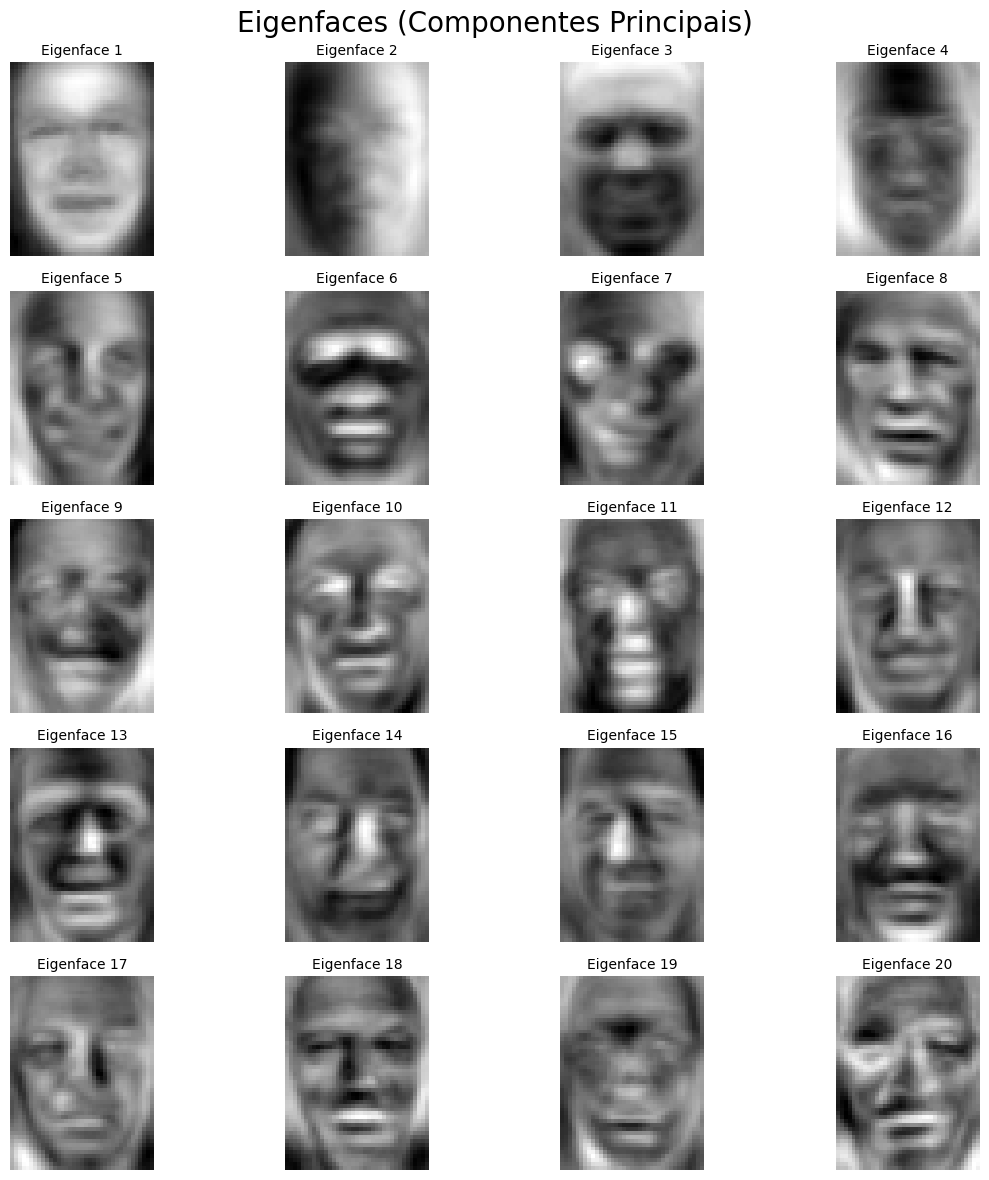

In [7]:
# Visualizar as eigenfaces (componentes principais)
n_eigenfaces = 20
# CORREÇÃO: pegar apenas os primeiros n_eigenfaces componentes antes do reshape
eigenfaces = pca.components_[:n_eigenfaces].reshape((n_eigenfaces, h, w))

fig, axes = plt.subplots(5, 4, figsize=(12, 12))
fig.suptitle('Eigenfaces (Componentes Principais)', fontsize=20)

for i, ax in enumerate(axes.flat):
    if i < n_eigenfaces:
        ax.imshow(eigenfaces[i], cmap='gray')
        ax.set_title(f'Eigenface {i+1}', fontsize=10)
        ax.axis('off')

plt.tight_layout()
plt.show()

## 4. Treinamento do Modelo de Classificação (SVM)

In [8]:
# Treinar classificador SVM
print("Treinando classificador SVM...")
classifier = SVC(kernel='rbf', class_weight='balanced', C=100, gamma=0.0001, random_state=42)
classifier.fit(X_train_pca, y_train)

print("Treinamento concluído!")

Treinando classificador SVM...
Treinamento concluído!


## 5. Avaliação do Modelo

In [9]:
# Predições
y_pred = classifier.predict(X_test_pca)
y_pred_train = classifier.predict(X_train_pca)

# Acurácias
accuracy_train = np.mean(y_pred_train == y_train)
accuracy_test = np.mean(y_pred == y_test)
difference = accuracy_train - accuracy_test

# Relatório
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=target_names))

print(f"\nAcurácia TREINO: {accuracy_train:.2%}")
print(f"Acurácia TESTE:  {accuracy_test:.2%}")
print(f"Diferença:      {difference:.2%}")

Relatório de Classificação:
                   precision    recall  f1-score   support

     Ariel Sharon       0.68      0.81      0.74        16
     Colin Powell       0.82      0.89      0.86        47
  Donald Rumsfeld       0.71      0.71      0.71        24
    George W Bush       0.91      0.91      0.91       106
Gerhard Schroeder       0.68      0.86      0.76        22
      Hugo Chavez       0.89      0.57      0.70        14
       Tony Blair       0.95      0.69      0.80        29

         accuracy                           0.83       258
        macro avg       0.81      0.78      0.78       258
     weighted avg       0.84      0.83      0.83       258


Acurácia TREINO: 96.89%
Acurácia TESTE:  83.33%
Diferença:      13.56%


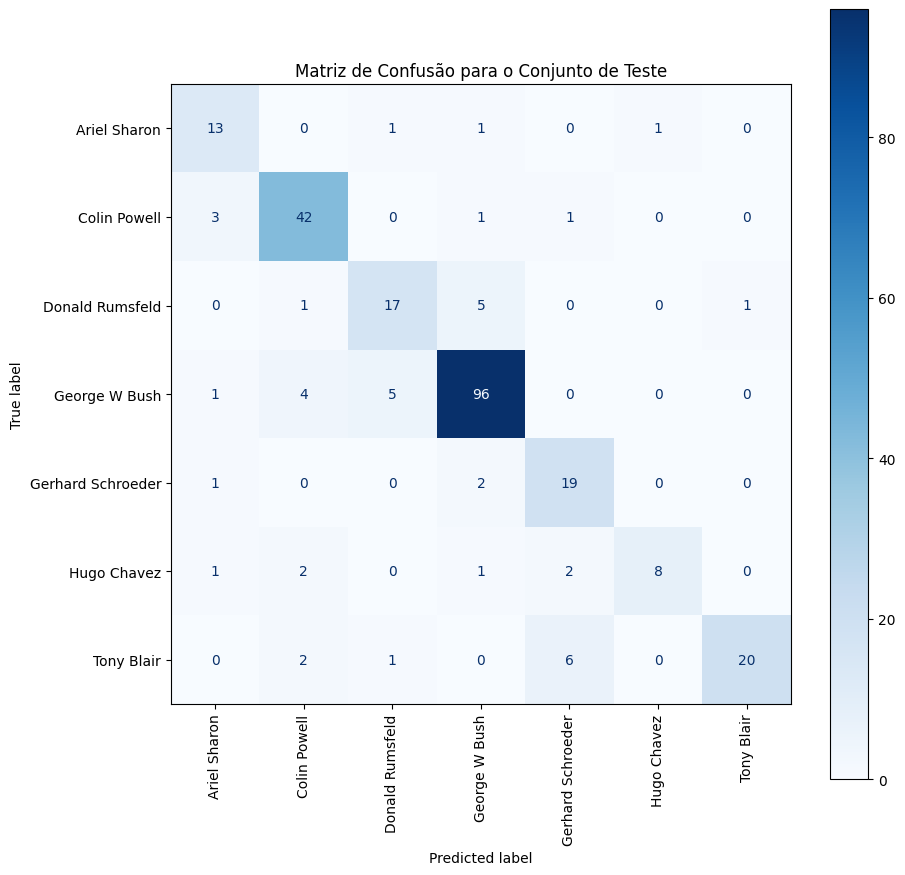

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Gerar a matriz de confusão
cm = confusion_matrix(y_test, y_pred, labels=np.arange(n_classes))

# Criar o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

# Plotar a matriz de confusão
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical', values_format='d')
ax.set_title('Matriz de Confusão para o Conjunto de Teste')
plt.show()

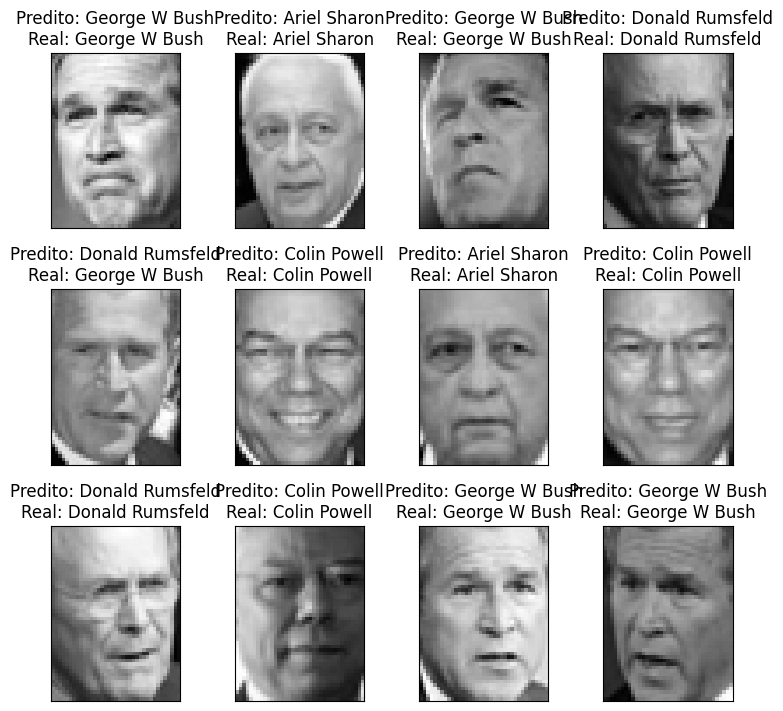

In [ ]:
# Visualizar algumas predições
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap='gray')
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

# Selecionar algumas amostras do teste
n_samples_to_show = 12
indices = np.random.choice(len(X_test), n_samples_to_show, replace=False)

prediction_titles = [
    f'Predito: {target_names[y_pred[i]]}\nReal: {target_names[y_test[i]]}'
    for i in indices
]

plot_gallery(X_test[indices], prediction_titles, h, w)
plt.show()